In [ ]:
##kerala_missing_values_LST

Total pixels inside Kerala: 38589
2020 June → LST missing: 13681/38589 (35.45%)
2020 June → Raw Precip missing: 8/38589 (0.02%)
2020 July → LST missing: 8885/38589 (23.02%)
2020 July → Raw Precip missing: 8/38589 (0.02%)
2020 August → LST missing: 4960/38589 (12.85%)
2020 August → Raw Precip missing: 8/38589 (0.02%)
2020 September → LST missing: 14065/38589 (36.45%)
2020 September → Raw Precip missing: 8/38589 (0.02%)
2021 June → LST missing: 1380/38589 (3.58%)
2021 June → Raw Precip missing: 8/38589 (0.02%)
2021 July → LST missing: 21716/38589 (56.28%)
2021 July → Raw Precip missing: 8/38589 (0.02%)
2021 August → LST missing: 17290/38589 (44.81%)
2021 August → Raw Precip missing: 8/38589 (0.02%)
2021 September → LST missing: 9514/38589 (24.65%)
2021 September → Raw Precip missing: 8/38589 (0.02%)
2022 June → LST missing: 4749/38589 (12.31%)
2022 June → Raw Precip missing: 8/38589 (0.02%)
2022 July → LST missing: 12717/38589 (32.95%)
2022 July → Raw Precip missing: 8/38589 (0.02%)
2022

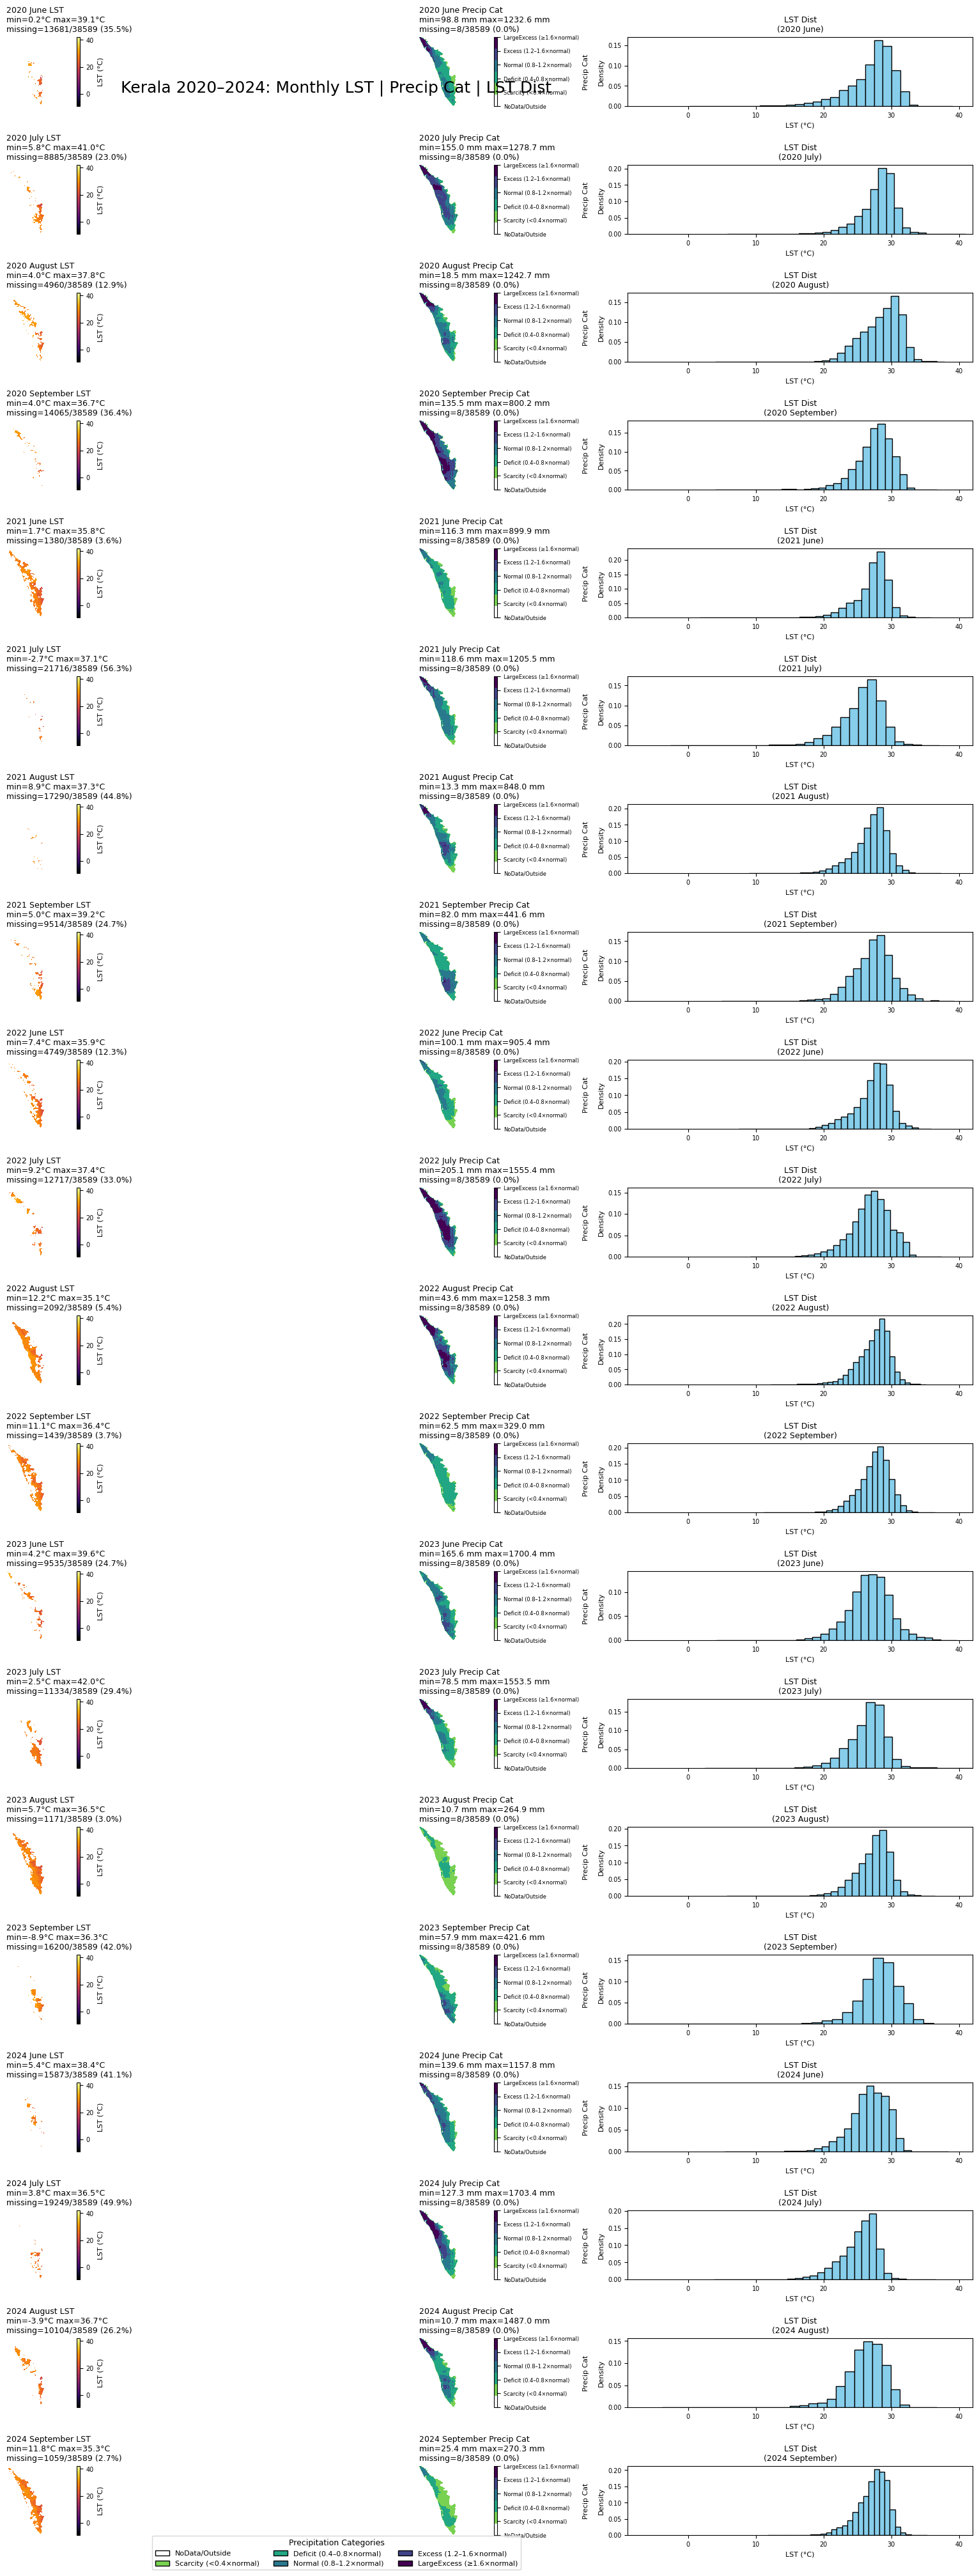

In [1]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Kerala)
# -----------------------------------------------------------------------------
lst_tiff_path        = "Kerala_X_LST.tif"                      # 20 bands (2020–2024 × 4: Jun–Sep)
precip_raw_tiff_path = "Kerala_Y_Precipitation_CHIRPS.tif"     # 25 bands (2020–2024 × 5)
precip_cat_tiff_path = "Kerala_Y_Precipitation_GT_geotif.tif"  # 25 bands (2020–2024 × 5)
india_shapefile      = "SateMask/gadm41_IND_1.shp"             # contains all Indian states

for p in (lst_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) LOAD INDIA STATES & BUILD KERALA MASK
# -----------------------------------------------------------------------------
gdf = gpd.read_file(india_shapefile)
gdf_ker = gdf[gdf["NAME_1"].str.lower() == "kerala"]
if gdf_ker.empty:
    raise ValueError("No 'Kerala' feature found in shapefile.")

with rasterio.open(lst_tiff_path) as src:
    transform = src.transform
    crs       = src.crs
    height    = src.height
    width     = src.width

if gdf_ker.crs != crs:
    gdf_ker = gdf_ker.to_crs(crs)

ker_geom = [gdf_ker.geometry.union_all()]
ker_mask = geometry_mask(
    ker_geom,
    transform=transform,
    invert=True,
    out_shape=(height, width)
)

total_inside = np.count_nonzero(ker_mask)
print(f"Total pixels inside Kerala: {total_inside}")

# -----------------------------------------------------------------------------
# 3) READ & MASK LST
# -----------------------------------------------------------------------------
with rasterio.open(lst_tiff_path) as src:
    lst_bands = src.read().astype(np.float32)  # (20, H, W)

if lst_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {lst_tiff_path}, found {lst_bands.shape[0]}")

for i in range(lst_bands.shape[0]):
    b = lst_bands[i]
    b[~ker_mask] = np.nan
    lst_bands[i] = b

# -----------------------------------------------------------------------------
# 4) READ & MASK RAW PRECIPITATION
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in raw precip, found {pr_raw_full.shape[0]}")

for i in range(pr_raw_full.shape[0]):
    arr = pr_raw_full[i]
    arr[~ker_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 5) READ & MASK PRECIPITATION CATEGORY
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in precip cat, found {pr_cat_full.shape[0]}")

for i in range(pr_cat_full.shape[0]):
    arr = pr_cat_full[i]
    arr[~ker_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 6) EXTRACT 20 MONTHLY BANDS (drop each year's “Total”)
# -----------------------------------------------------------------------------
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs += [base + m for m in range(4)]

precip_raw_bands = pr_raw_full[monthly_idxs]  # (20, H, W)
precip_cat_bands = pr_cat_full[monthly_idxs]  # (20, H, W)

# -----------------------------------------------------------------------------
# 7) SETUP YEARS, MONTHS & COLORMAPS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
months      = ["June", "July", "August", "September"]
n_years, n_months = len(years), len(months)
n_total     = n_years * n_months  # 20

all_lst = lst_bands.flatten()
all_lst = all_lst[~np.isnan(all_lst)]
lst_vmin = float(np.nanmin(all_lst)) if all_lst.size else 0.0
lst_vmax = float(np.nanmax(all_lst)) if all_lst.size else 50.0
lst_cmap = plt.get_cmap("inferno")

cluster_colors = ["#ffffff", "#79d151", "#22a784", "#29788e", "#404387", "#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit (0.4–0.8×normal)",
    3: "Normal (0.8–1.2×normal)",
    4: "Excess (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Kerala 2020–2024: Monthly LST | Precip Cat | LST Dist", fontsize=18, y=0.97)
if n_total == 1:
    axes = axes[np.newaxis, :]

# -----------------------------------------------------------------------------
# 9) LOOP & PLOT WITH MISSING STATS
# -----------------------------------------------------------------------------
for i in range(n_total):
    yidx, midx = divmod(i, n_months)
    year, mon = years[yidx], months[midx]

    # LST
    layer = lst_bands[i]
    valid = layer[~np.isnan(layer)]
    mn, mx = (float(np.nanmin(valid)), float(np.nanmax(valid))) if valid.size else (np.nan, np.nan)
    miss_lst = np.count_nonzero(np.isnan(layer[ker_mask]))
    pct_lst  = miss_lst / total_inside * 100
    print(f"{year} {mon} → LST missing: {miss_lst}/{total_inside} ({pct_lst:.2f}%)")

    # Precip
    pr_layer = precip_raw_bands[i]
    vpr = pr_layer[~np.isnan(pr_layer)]
    pr_min, pr_max = (float(np.nanmin(vpr)), float(np.nanmax(vpr))) if vpr.size else (np.nan, np.nan)
    miss_pr = np.count_nonzero(np.isnan(pr_layer[ker_mask]))
    pct_pr  = miss_pr / total_inside * 100
    print(f"{year} {mon} → Raw Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # Category
    rc = precip_cat_bands[i]
    cp = np.zeros_like(rc, dtype=np.int8)
    ok = (rc != -1)
    cp[ok] = rc[ok] + 1

    # Column 0
    ax0 = axes[i,0]
    im0 = ax0.imshow(layer, cmap=lst_cmap, vmin=lst_vmin, vmax=lst_vmax)
    t0 = (f"{year} {mon} LST\nmin={mn:.1f}°C max={mx:.1f}°C\n"
          f"missing={miss_lst}/{total_inside} ({pct_lst:.1f}%)")
    ax0.set_title(t0, loc="left", fontsize=9)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    c0.set_label("LST (°C)", fontsize=8)
    c0.ax.tick_params(labelsize=7)

    # Column 1
    ax1 = axes[i,1]
    im1 = ax1.imshow(cp, cmap=cluster_cmap, vmin=0, vmax=5)
    t1 = (f"{year} {mon} Precip Cat\nmin={pr_min:.1f} mm max={pr_max:.1f} mm\n"
          f"missing={miss_pr}/{total_inside} ({pct_pr:.1f}%)")
    ax1.set_title(t1, loc="left", fontsize=9)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=6); c1.set_label("Precip Cat", fontsize=8)

    # Column 2
    ax2 = axes[i,2]
    if valid.size:
        ax2.hist(valid.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(lst_vmin, lst_vmax)
    else:
        ax2.text(0.5,0.5,"No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"LST Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("LST (°C)", fontsize=8)
    ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) LEGEND
# -----------------------------------------------------------------------------
fig.legend(
    handles=cluster_handles,
    labels=[cluster_labels[j] for j in range(6)],
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precipitation Categories",
    fontsize=8,
    title_fontsize=9,
    bbox_to_anchor=(0.5, -0.005)
)

plt.show()
